# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries
import pyspark
import numpy as np
import pandas as pd
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql import types, Window, functions as f
from pyspark.sql import DataFrame
from functools import reduce
from pyspark.sql.types import IntegerType,StringType
from typing import Dict, Any
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import *

In [3]:
# create a SparkSession: note this step was left out of the screencast
spark = (
    SparkSession.builder
    .master("local")
    .appName("Udacity Capstone")
    .getOrCreate()
)

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
df = spark.read.json("mini_sparkify_event_data.json")

### Total Record

In [5]:
df.count()

286500

### Check Missing User Id

In [6]:
df.where(
    (f.col("userId")=='')|
    (f.col("userId").isNull())|
    (f.col("userId")=='-')
).count()

8346

In [7]:
invalid_userid = (
    df.where(
        (f.col("userId")=='')|
        (f.col("userId").isNull())|
        (f.col("userId")=='-')
    )
)

In [8]:
invalid_userid.select("auth").distinct().toPandas()

,auth
0,Logged Out
1,Guest


Invalid userId are due to logged out session or Guest

In [9]:
df.where(
    (f.col("sessionId")=='')|
    (f.col("sessionId").isNull())|
    (f.col("sessionId")=='-')
).count()

0

### Filter out Missing UserId

In [10]:
df = (
    df.where(
    (f.col("userId")!='')&
    (~f.col("userId").isNull())&
    (f.col("userId")!='-'))
)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

<b>total user<b>

In [11]:
df.select("userId").distinct().count()

225

<b>total trx<b>

In [12]:
df.count()

278154

### labeling churn

In [13]:
is_churn_label = (
    df
    .withColumn("is_churn",
                f.when(f.col("page")=='Cancellation Confirmation',f.lit(1))
                .otherwise(f.lit(0))
               )
    .groupby("userId")
    .agg(f.max("is_churn").alias("is_churn"))
)

In [14]:
is_churn_label.count()

225

<b>Add Length of Stay (LoS) Feature<b>

In [15]:
df_exploration = (
    df
    .withColumn("los_days",f.round((f.col("ts")-f.col("registration"))/f.lit(24*3600*1000),0))
    .withColumn("los_flag",
                f.when(f.col("los_days")<30,f.lit("1.<30d"))
                .when(f.col("los_days").between(30,60),f.lit("2.30d-60d"))
                .when(f.col("los_days").between(60,180),f.lit("3.60d-180d"))
                .when(f.col("los_days").between(180,360),f.lit("4.180d-360d"))
                .when(f.col("los_days")>360,f.lit("5.360d+"))
               )
)

In [16]:
df_exploration = (
    df_exploration
    .withColumn("itemInSession_flag",
                f.when(f.col("itemInSession")<5,f.lit("1.<5"))
                .when(f.col("itemInSession").between(5,10),f.lit("2.5-10"))
                .when(f.col("itemInSession").between(10,20),f.lit("3.10-20"))
                .when(f.col("itemInSession").between(20,50),f.lit("4.20-50"))
                .when(f.col("itemInSession").between(50,100),f.lit("5.50-100"))
                .when(f.col("itemInSession").between(100,200),f.lit("6.100-200"))
                .when(f.col("itemInSession").between(200,500),f.lit("7.200-500"))
                .when(f.col("itemInSession")>500,f.lit("8.500+"))
               )
)

How many row have missing length?

In [17]:
df.where(f.col("length").isNull()).count()

50046

In [18]:
df_exploration = (
    df_exploration
    .withColumn("length_flag",
                f.when(f.col("itemInSession")<5,f.lit("1.<5"))
                .when(f.col("itemInSession").between(5,10),f.lit("2.5-10"))
                .when(f.col("itemInSession").between(10,20),f.lit("3.10-20"))
                .when(f.col("itemInSession").between(20,50),f.lit("4.20-50"))
                .when(f.col("itemInSession").between(50,100),f.lit("5.50-100"))
                .when(f.col("itemInSession").between(100,200),f.lit("6.100-200"))
                .when(f.col("itemInSession").between(200,500),f.lit("7.200-500"))
                .when(f.col("itemInSession")>500,f.lit("8.500+"))
               )
)

In [19]:
df_exploration = (
    df_exploration
    .join(is_churn_label,on="userId",how='left')
    .fillna(0,subset=['is_churn'])
    .cache()
)

### Identifying potential feature for churn prediction

In [20]:
def churn_slice_n_dice(by_column, distinct_user=False):
    count_statement = (f.countDistinct("userId") if distinct_user else f.count("userId"))
    
    churn_summary = (
        df_exploration
        .groupby(by_column)
        .pivot("is_churn")
        .agg(count_statement)
        .withColumn("churn_rate",f.col("1")/(f.col("1")+f.col("0")))
        .orderBy(f.col(by_column).asc())
    )
    
    return churn_summary.toPandas()

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Churn summary dataframes you've calculated
level_churn_summary = churn_slice_n_dice("level")
gender_churn_summary = churn_slice_n_dice("gender")
los_churn_summary = churn_slice_n_dice("los_flag")
itemInSession_churn_summary = churn_slice_n_dice("itemInSession_flag")

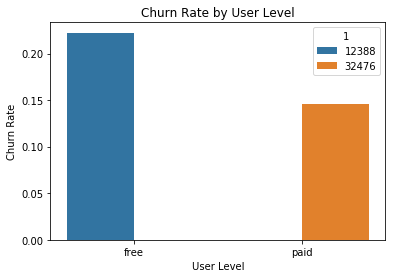

In [22]:
# Visualize churn rate by user level
plt.figure(figsize=(6, 4))
sns.barplot(data=level_churn_summary, x='level', y='churn_rate', hue='1')
plt.title('Churn Rate by User Level')
plt.xlabel('User Level')
plt.ylabel('Churn Rate')
plt.show()

Free user have higher churn rate both in transaction level and user aggregate level

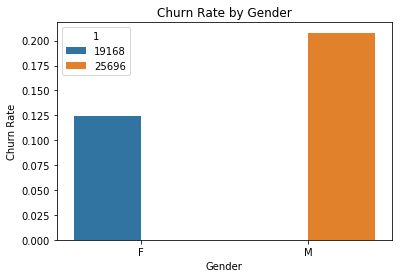

In [23]:
# Visualize churn rate by gender
plt.figure(figsize=(6, 4))
sns.barplot(data=gender_churn_summary, x='gender', y='churn_rate', hue='1')
plt.title('Churn Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Churn Rate')
plt.show()

Male have higher churn rate than female both in transaction level and user aggregate level

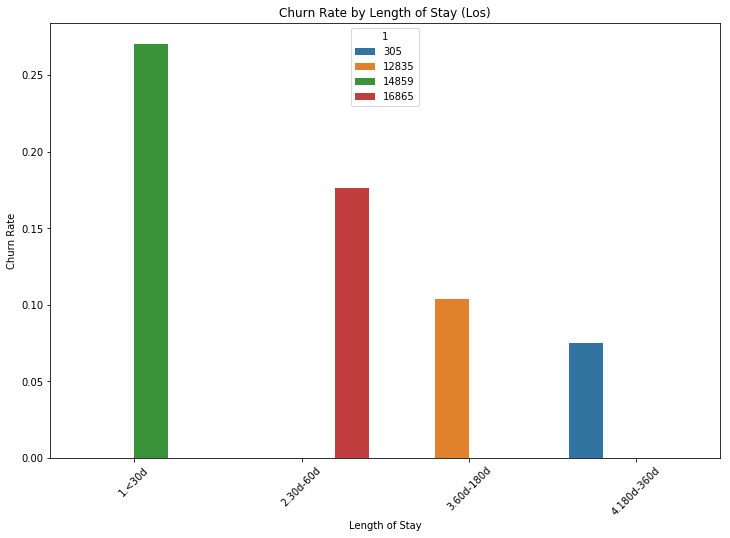

In [24]:
# Visualize churn rate by Length of Stay (Los)
plt.figure(figsize=(6, 4))
sns.barplot(data=los_churn_summary, x='los_flag', y='churn_rate', hue='1')
plt.title('Churn Rate by Length of Stay (Los)')
plt.xlabel('Length of Stay')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()

Customer churn rate negatively correlated with Los

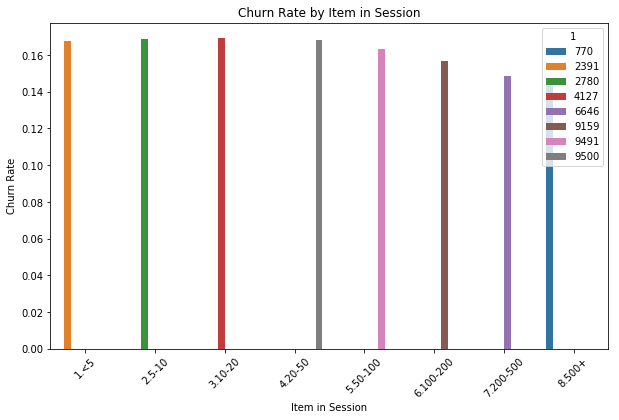

In [34]:
# Visualize churn rate by itemInSession
plt.figure(figsize=(10, 6))
sns.barplot(data=itemInSession_churn_summary, x='itemInSession_flag', y='churn_rate', hue='1')
plt.title('Churn Rate by Item in Session')
plt.xlabel('Item in Session')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()

Customer with item in session > 100 have noticable lower churn rate

In [27]:
df.limit(100).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [13]:
class FilterInvalidUser(Transformer):
    def __init__(self):
        pass

    def _transform(self, df: DataFrame) -> DataFrame:
        return df.where(~f.col("auth").isin(["Logged Out","Guest"]))
    
class CalculateDate(Transformer):
    def __init__(self):
        pass

    def _fit(self, df: DataFrame) -> DataFrame:
        df = (
            df
            .withColumn('activity_timestamp', f.from_unixtime(f.col('ts').cast(LongType())/1000).cast(TimestampType()))
            .withColumn('activity_date', f.from_unixtime(f.col('ts')/1000).cast(DateType()))
            .withColumn('registration_timestamp', f.from_unixtime(f.col('registration').cast(LongType())/1000).cast(TimestampType()))
            .withColumn('registration_date', f.from_unixtime(f.col('ts')/1000).cast(DateType()))
            .withColumn("los_hour",(f.col("activity_timestamp").cast("long") - f.col("registration_timestamp").cast("long"))/(3600))
            .withColumn("los_day",(f.col("activity_timestamp").cast("long") - f.col("registration_timestamp").cast("long"))/(3600*24))
        )
        return df
    
    def _transform(self, df: DataFrame) -> DataFrame:
        return self._fit(df)

class GenerateAggregatedFeatures(Transformer):
    def __init__(self, aggregate_window_in_days=1):
        self.aggregate_window_in_days=aggregate_window_in_days
    
    def _fit(self, df: DataFrame) -> DataFrame:
        i = self.aggregate_window_in_days
        days = lambda i: i * 86400
        w = Window.orderBy(f.col("activity_timestamp").cast('long')).rangeBetween(-days(1), 0)
        
        df = (
            df
            .withColumn(f'count_activity_{i}d', f.size(f.collect_set("sessionId").over(w)))
            .withColumn(f'time_spent_{i}d', f.sum("length").over(w))
        )
        return df
    
    def _transform(self, df: DataFrame) -> DataFrame:
        return self._fit(df)

def get_churn_flag(df):
    is_churn_label = (
        df
        .withColumn("is_churn",
                    f.when(f.col("page")=='Cancellation Confirmation',f.lit(1))
                    .otherwise(f.lit(0)))
        .groupby("userId")
        .agg(f.max("is_churn").alias("is_churn"))
    )

    df = (
        df
        .join(is_churn_label,on="userId",how='left')
        .fillna(0,subset=['is_churn'])
    )
    return df

In [14]:
full_dataset = get_churn_flag(df)
(trainingData, testData) = full_dataset.randomSplit([0.7, 0.3])

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [15]:
def pipeline_builder(model):
    features_columns = ["level","gender","los_day","itemInSession"]
    label_column = "is_churn"

    filter_invalid_user = FilterInvalidUser()
    calculate_date = CalculateDate()
    generate_daily_feature = GenerateAggregatedFeatures(1)
    gender_indexer = StringIndexer(inputCol="gender", outputCol="genderIndex")
    level_indexer = StringIndexer(inputCol="level", outputCol="levelIndex")
    gender_encoder = OneHotEncoder(inputCol="genderIndex", outputCol="genderVec")
    level_encoder = OneHotEncoder(inputCol="levelIndex", outputCol="levelVec")

    assembler = VectorAssembler(inputCols=[
        "los_hour","itemInSession",
        "count_activity_1d","time_spent_1d",
        "genderVec","levelVec",
    ], outputCol="features")
    label_indexer = StringIndexer(inputCol=label_column, outputCol="indexed_label")
    if model == "GBTClassifier":
        model = GBTClassifier(labelCol="indexed_label", featuresCol="features")
    elif model == "RandomForestClassifier":
        model = RandomForestClassifier(labelCol="indexed_label", featuresCol="features")
    elif model == "DecisionTreeClassifier":
        model = DecisionTreeClassifier(labelCol="indexed_label", featuresCol="features")
        


    pipeline = Pipeline(stages=[
        filter_invalid_user,
        calculate_date,
        generate_daily_feature,
        gender_indexer,
        level_indexer,
        gender_encoder,
        level_encoder,
        assembler,
        label_indexer,
        model,
    ])
    return pipeline

In [16]:
for model_type in ["DecisionTreeClassifier","RandomForestClassifier","GBTClassifier"]:
    pipeline = pipeline_builder(model_type)
    pipeline = pipeline.fit(trainingData)

    # Generate test score
    test_score = pipeline.transform(testData)
    evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction")
    # Calculate the area under the ROC curve (AUC)
    f1 = evaluator.evaluate(test_score, {evaluator.metricName: "f1"})
    print("==================================================")
    print("Model:", model_type)
    print("F1 Score:", f1)

Model: DecisionTreeClassifier
F1 Score: 0.7890650617242865
Model: RandomForestClassifier
F1 Score: 0.7800159477800256
Model: GBTClassifier
F1 Score: 0.8041381259320414


## Summary

### Feature Engineering and Preprocessing:
The code begins by emphasizing the importance of feature engineering, directing attention to the creation of relevant features for training predictive models. To accommodate the full dataset, a script is proposed that first operates on a smaller subset of data and can be scaled up using best practices for improved efficiency.

Several custom transformer classes are defined to preprocess the data effectively:

<b>FilterInvalidUser</b>: This transformer filters out user data with invalid authentication statuses, removing entries with "Logged Out" or "Guest" authentication.

<b>CalculateDate</b>: This transformer computes essential date-related features such as activity timestamps, activity dates, registration timestamps, registration dates, length of stay in hours (los_hour), and length of stay in days (los_day).

<b>GenerateAggregatedFeatures</b>: This transformer aggregates user activities within a specified time window to create features like the count of activities (count_activity_1d) and total time spent (time_spent_1d).

<b>get_churn_flag</b>: This function adds a churn label to users based on the presence of a "Cancellation Confirmation" page in their activity. It groups by userId and assigns a binary churn label.

### Modeling and Evaluation:
The code transitions to the modeling phase by splitting the data into training and test sets, adhering to a 70-30 split ratio. Three machine learning models are evaluated:

1. Decision Tree Classifier
2. Random Forest Classifier
3. Gradient Boosted Tree Classifier (GBT)

### Model Performance
In summary, the model evaluation results indicate that the Gradient Boosted Tree Classifier (GBT) outperforms the other models, achieving the highest F1 score of <b>0.804</b>. This suggests that the GBT model is particularly effective in identifying potential churn instances within the dataset. The Decision Tree and Random Forest models also perform well with F1 scores of <b>0.789</b> and <b>0.780</b>, respectively. These results provide valuable guidance for selecting the most suitable model for predicting user churn, contributing to better decision-making and customer retention strategies.

Some area for model performance improvement are exploring additional features such as geographical feature and clustering customer based on music genre. Additionally, AB testing should be performed before implementing it to larger scale customer, we can set treatment group which get churn prevention treatment such as promo or loyalty program & control group that receive no treatment.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.